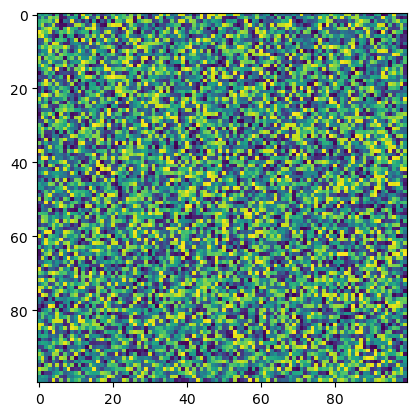

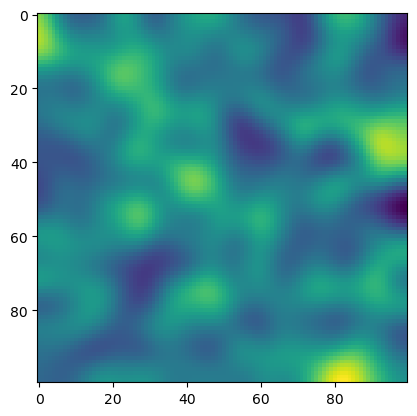

In [13]:
import numpy as np
from scipy.ndimage import laplace

def minimum_curvature(input_matrix, num_iterations=100, alpha=0.1):
    for _ in range(num_iterations):
        # Calculate the Laplacian of the input matrix
        laplacian = laplace(input_matrix)

        # Update the input matrix using the Laplacian and a smoothing factor (alpha)
        input_matrix += alpha * laplacian

    return input_matrix

# Generate a sample input matrix
input_matrix = np.random.rand(100, 100)

plt.imshow(input_matrix)
plt.show()

# Apply minimum curvature
output_matrix = minimum_curvature(input_matrix)

# You can display the results or further process the 'output_matrix' as needed



plt.imshow(output_matrix)
plt.show()



In [14]:
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import warnings

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)




3.10.8 | packaged by conda-forge | (main, Nov  4 2022, 13:42:51) [MSC v.1916 64 bit (AMD64)]


In [2]:
# ----------------------------------------------------------------------------------------------

# creating directives and additional classes

#

#plot learned mref
class plot_mref(directives.InversionDirective):

    mesh = None
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        meshCore = self.mesh
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            1 / np.exp(self.opt.xc), ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        # utils.plot2Ddata(
        #     meshCore.gridCC,1 / np.exp(mtrue[actcore]),nx=500,ny=500,
        #     contourOpts={'alpha':0},
        #     clim=[0,500],
        #     ax=ax[0],
        #     level=True,
        #     ncontour=2,
        #     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        #     method='nearest'
        # )

        ax[2].hist(1 / np.exp(self.opt.xc), 100)
        # ax[2].set_aspect(1)

        # ax[0].set_ylim([-15,0])
        # ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        # ax[1].set_ylim([-15,0])
        # ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        fig.savefig(f'./iterations/{self.start}.png')
        np.save(f'./iterations/model_{self.start}.npy', self.opt.xc)
        self.start += 1

# update the neighbors
class update_segmentation_neighbours(directives.InversionDirective):
    
    def initialize(self):
        self.count = 0
        # self.endIter()

        pgi_reg = self.reg.get_functions_of_type(PGIsmallness)
        if len(pgi_reg) != 1:
            raise UserWarning(
                "'PGI_UpdateParameters' requires one 'PGIsmallness' regularization "
                "in the objective function."
            )
        self.pgi_reg = pgi_reg[0]
    
    def endIter(self):

        print(f"iteration: {self.opt.iter}")
        if self.count > 15:

            self.pgi_reg.gmmref.segment(self.opt.xc)

            self.pgi_reg.gmm = self.pgi_reg.gmmref

            result = self.pgi_reg.gmm.masks
            fig, ax = plt.subplots(3,2, figsize=(10, 10))
            result[0].keys()
            # ax[0, 0].imshow(np.log(model.reshape(self.mesh.shape_cells, order='F')).T)
            ax[0, 0].invert_yaxis()
            ax[0, 0].set_title('PGI recovered model')

            # for i in range(4):
            ax[0, 1].imshow(result[1]['segmentation'].T)
            ax[0, 1].invert_yaxis()
            ax[0, 1].set_title('SAM segmentation item 1')
            if len(result) > 2:
                ax[1, 0].imshow(result[2]['segmentation'].T)
                ax[1, 0].invert_yaxis()
                ax[1, 0].set_title('SAM segmentation item 2')
                ax[1, 1].imshow(result[3]['segmentation'].T)
                ax[1, 1].invert_yaxis()
                ax[1, 1].set_title('SAM segmentation item 3')
                ax[2, 0].imshow(result[0]['segmentation'].T)
                ax[2, 0].invert_yaxis()
                ax[2, 0].set_title('SAM segmentation item 0')
                ax[2, 1].imshow(result[4]['segmentation'].T)
                ax[2, 1].invert_yaxis()
                ax[2, 1].set_title('SAM segmentation item 0')
            plt.tight_layout()
            plt.show()

        else:

            self.count += 1


class PGIUpdateParameters(directives.InversionDirective):
    """
    This directive is to be used with regularization from regularization.pgi.

    Custom PGI_UpdateParameters class that updates the reference model only
    after the data misfits targets have been achieved.

    It updates:
        - the reference model and weights in the smallness (L2-approximation of PGI)
        - the GMM as a MAP estimate between the prior and the current model
    For more details, please consult:
     - https://doi.org/10.1093/gji/ggz389
    """

    verbose = False  # print info.  about the GMM at each iteration
    update_rate = 1  # updates at each `update_rate` iterations
    update_gmm = False  # update the GMM
    zeta = (
        1e10  # confidence in the prior proportions; default: high value, keep GMM fixed
    )
    nu = (
        1e10  # confidence in the prior covariances; default: high value, keep GMM fixed
    )
    kappa = 1e10  # confidence in the prior means;default: high value, keep GMM fixed
    update_covariances = (
        True  # Average the covariances, If false: average the precisions
    )
    fixed_membership = None  # keep the membership of specific cells fixed
    keep_ref_fixed_in_Smooth = True  # keep mref fixed in the Smoothness
    update_reference_model = (
        False  # don't update reference model until data misfits targets are hit
    )

    def initialize(self):
        pgi_reg = self.reg.get_functions_of_type(PGIsmallness)
        if len(pgi_reg) != 1:
            raise UserWarning(
                "'PGI_UpdateParameters' requires one 'PGIsmallness' regularization "
                "in the objective function."
            )
        self.pgi_reg = pgi_reg[0]

    def endIter(self):
        if self.opt.iter > 0 and self.opt.iter % self.update_rate == 0:
            m = self.invProb.model
            modellist = self.pgi_reg.wiresmap * m
            model = np.c_[[a * b for a, b in zip(self.pgi_reg.maplist, modellist)]].T

            if self.update_gmm and isinstance(
                self.pgi_reg.gmmref, GaussianMixtureWithNonlinearRelationships
            ):
                clfupdate = GaussianMixtureWithNonlinearRelationshipsWithPrior(
                    gmmref=self.pgi_reg.gmmref,
                    zeta=self.zeta,
                    kappa=self.kappa,
                    nu=self.nu,
                    verbose=self.verbose,
                    prior_type="semi",
                    update_covariances=self.update_covariances,
                    max_iter=self.pgi_reg.gmm.max_iter,
                    n_init=self.pgi_reg.gmm.n_init,
                    reg_covar=self.pgi_reg.gmm.reg_covar,
                    weights_init=self.pgi_reg.gmm.weights_,
                    means_init=self.pgi_reg.gmm.means_,
                    precisions_init=self.pgi_reg.gmm.precisions_,
                    random_state=self.pgi_reg.gmm.random_state,
                    tol=self.pgi_reg.gmm.tol,
                    verbose_interval=self.pgi_reg.gmm.verbose_interval,
                    warm_start=self.pgi_reg.gmm.warm_start,
                    fixed_membership=self.fixed_membership,
                )
                clfupdate = clfupdate.fit(model)

            elif self.update_gmm and isinstance(
                self.pgi_reg.gmmref, WeightedGaussianMixture
            ):
                clfupdate = GaussianMixtureWithPrior(
                    gmmref=self.pgi_reg.gmmref,
                    zeta=self.zeta,
                    kappa=self.kappa,
                    nu=self.nu,
                    verbose=self.verbose,
                    prior_type="semi",
                    update_covariances=self.update_covariances,
                    max_iter=self.pgi_reg.gmm.max_iter,
                    n_init=self.pgi_reg.gmm.n_init,
                    reg_covar=self.pgi_reg.gmm.reg_covar,
                    weights_init=self.pgi_reg.gmm.weights_,
                    means_init=self.pgi_reg.gmm.means_,
                    precisions_init=self.pgi_reg.gmm.precisions_,
                    random_state=self.pgi_reg.gmm.random_state,
                    tol=self.pgi_reg.gmm.tol,
                    verbose_interval=self.pgi_reg.gmm.verbose_interval,
                    warm_start=self.pgi_reg.gmm.warm_start,
                    fixed_membership=self.fixed_membership,
                )
                clfupdate = clfupdate.fit(model)

            else:
                clfupdate = copy.deepcopy(self.pgi_reg.gmmref)

            self.pgi_reg.gmm = clfupdate
            membership = self.pgi_reg.gmm.predict(model)

            if self.fixed_membership is not None:
                membership[self.fixed_membership[:, 0]] = self.fixed_membership[:, 1]

            if getattr(self.fixed_membership, "shape", [0, 0])[0] < len(membership):
                self.pgi_reg._r_second_deriv = None

            # Start updating reference model after we hit the data misfit targets
            if self.data_misfits_achieved:
                self.update_reference_model = True

            # Update reference model after data misfits targets have been hit
            if self.update_reference_model:
                print("updating reference model")
                mref = mkvc(self.pgi_reg.gmm.means_[membership])
                self.pgi_reg.reference_model = mref

    @property
    def data_misfits_achieved(self):
        """Returns True if data misfits have been achieved"""
        return self.multi_target_misfits_directive.DM

    @property
    def directives(self):
        """List of all the directives in the :class:`SimPEG.inverison.BaseInversion``."""
        return self.inversion.directiveList.dList

    @property
    def multi_target_misfits_directive(self):
        """``MultiTargetMisfit`` directive in the :class:`SimPEG.inverison.BaseInversion``."""
        if not hasattr(self, "_mtm_directive"):
            # Obtain multi target misfits directive from the directive list
            multi_target_misfits_directive = [
                directive
                for directive in self.directives
                if isinstance(directive, directives.MultiTargetMisfits)
            ]
            if not multi_target_misfits_directive:
                raise UserWarning(
                    "No MultiTargetMisfits directive found in the current inversion. "
                    "A MultiTargetMisfits directive is needed by the "
                    "PGI_BetaAlphaSchedule directive."
                )
            (self._mtm_directive,) = multi_target_misfits_directive
        return self._mtm_directive


class SavePGIOutput(directives.InversionDirective):
    """
    Directive to save items of interest during the course of an inversion

    Inspired in custom class from:
    https://github.com/simpeg/transform-2020-simpeg
    """

    def __init__(self, path):
        """
        Initialize the directive

        Parameters
        ----------
        path : str or path-like object
        """
        super().__init__()
        # Convert path to Path if it's a str
        if type(path) == str:
            path = Path(path)
        # Create the parent dir if it doesn't exists
        if not path.parent.exists():
            os.makedirs(str(path.parent))
        # Warn the user if the file already exists
        if path.exists():
            if path.is_dir():
                raise ValueError(f"Path '{path}' is a directory and already exists.")
            warnings.warn(
                f"File '{path}' already exists. If you continue it will be overwritten",
                UserWarning,
            )
        self.path = path
        self.count = 0

    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results
        self._columns = (
            "iteration",
            "beta",
            "alpha_pgi",
            "alpha_smooth",
            "alpha_x",
            "alpha_y",
            "alpha_z",
            "phi_d",
            "phi_m",
            "phi_m_pgi",
            "phi_m_smooth_x",
            "phi_m_smooth_y",
            "phi_m_smooth_z",
            "phims",
        )
        self.inversion_results = {column: [] for column in self._columns}
        # create output file
        with open(self.path, "w") as f:
            f.write(f"# Output of inversion run on {self.count}\n")
            f.write("# " + "\t".join(self._columns) + "\n")

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append
        the new values to our dictionary
        """

        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["beta"].append(self.invProb.beta)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["phi_m"].append(self.invProb.phi_m)

        # grab the components of the regularization and evaluate them here
        # the regularization has a list of objective functions
        # objfcts = [PGIsmallness, WeightedLeastSquares]
        # and the multipliers contain the alpha values
        # multipliers = [alpha_pgi, alpha_wls]
        pgi, weighted_least_squares = self.reg.objfcts[:]
        pgi_multiplier, wls_multiplier = self.reg.multipliers[:]
        self.inversion_results["alpha_pgi"].append(pgi_multiplier)
        self.inversion_results["alpha_smooth"].append(wls_multiplier)
        self.inversion_results["phi_m_pgi"].append(
            pgi(self.invProb.model) * pgi_multiplier
        )

        # WeightedLeastSquares has inside all type of regularizations in the
        # following order:
        #   smallness, x_smoothness, xx, y_smoothness, yy, z_smoothness, zz.
        # We just want the *_smoothness ones.
        x_smooth = weighted_least_squares.objfcts[1]
        x_smooth_multiplier = weighted_least_squares.multipliers[1]
        alpha_x = wls_multiplier * x_smooth_multiplier
        self.inversion_results["alpha_x"].append(alpha_x)
        self.inversion_results["phi_m_smooth_x"].append(
            x_smooth(self.invProb.model) * alpha_x
        )
        y_smooth = weighted_least_squares.objfcts[3]
        y_smooth_multiplier = weighted_least_squares.multipliers[3]
        alpha_y = wls_multiplier * y_smooth_multiplier
        self.inversion_results["alpha_y"].append(alpha_y)
        self.inversion_results["phi_m_smooth_y"].append(
            y_smooth(self.invProb.model) * alpha_y
        )
        # z_smooth = weighted_least_squares.objfcts[5]
        # z_smooth_multiplier = weighted_least_squares.multipliers[5]
        # alpha_z = wls_multiplier * z_smooth_multiplier
        # self.inversion_results["alpha_z"].append(alpha_z)
        # self.inversion_results["phi_m_smooth_z"].append(
        #     z_smooth(self.invProb.model) * alpha_z
        # )

        # Get phims
        phims = self._get_phims()
        self.inversion_results["phims"].append(phims)

        # append values to the output file
        values = [
            f"{self.inversion_results[column][-1]:.2e}"
            if column != "iteration"
            else f"{self.inversion_results[column][-1]:d}"
            for column in self._columns
        ]
        with open(self.path, "a") as f:
            f.write("\t".join(values) + "\n")

    def _get_phims(self):
        """
        Return the value of `phims` at the end of the current iteration

        A.k.a. smallness misfit or clusterization misfit
        """
        # Get list of all directives in the inversion
        directives_list = self.inversion.directiveList.dList
        # Get the MultiTargetMisfits
        multi_target_misfit_directive = [
            directive
            for directive in directives_list
            if isinstance(directive, MultiTargetMisfits)
        ]
        if not multi_target_misfit_directive:
            raise ValueError("No MultiTargetMisfits directive found in the inversion.")
        if len(multi_target_misfit_directive) > 1:
            raise ValueError(
                "Multiple MultiTargetMisfits directives found in the inversion."
            )
        multi_target_misfit_directive = multi_target_misfit_directive[0]
        # Compute phims
        return multi_target_misfit_directive.phims()


def calculate_iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) between two binary masks.

    Parameters:
        mask1 (numpy.ndarray): The first binary mask.
        mask2 (numpy.ndarray): The second binary mask.

    Returns:
        float: The Intersection over Union (IoU) score.
    """
    
    # Ensure the masks have the same shape
    if mask1.shape != mask2.shape:
        raise ValueError("Mask shapes do not match.")

    # Convert masks to binary (0 or 1) values
    mask1 = np.array(mask1 > 0, dtype=np.uint8)
    mask2 = np.array(mask2 > 0, dtype=np.uint8)

    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    iou = intersection / union if union > 0 else 0.0
    return iou


class GaussianMixtureSam(utils.WeightedGaussianMixture):

    def __init__(
        self,
        n_components,
        mesh,
        actv=None,
        kdtree=None,
        indexneighbors=None,
        boreholeidx=None,
        T=12.,
        masks=None,
        kneighbors=0,
        norm=2,
        init_params='kmeans',
        max_iter=100,
        covariance_type='full',
        means_init=None,
        n_init=10, 
        precisions_init=None,
        random_state=None, 
        reg_covar=1e-06, 
        tol=0.001, 
        verbose=0,
        verbose_interval=10, 
        warm_start=False, 
        weights_init=None,
        anisotropy=None,
        index_anisotropy=None, # Dictionary with anisotropy and index
        index_kdtree=None,# List of KDtree
        segmentation_model_checkpoint=r"C:\Users\johnk\Documents\git\jresearch\PGI\dcip\sam_vit_h_4b8939.pth",
        #**kwargs
    ):

        super(GaussianMixtureSam, self).__init__(
            n_components=n_components,
            mesh=mesh,
            actv=actv,
            covariance_type=covariance_type,
            init_params=init_params,
            max_iter=max_iter,
            means_init=means_init,
            n_init=n_init,
            precisions_init=precisions_init,
            random_state=random_state,
            reg_covar=reg_covar,
            tol=tol,
            verbose=verbose,
            verbose_interval=verbose_interval,
            warm_start=warm_start,
            weights_init=weights_init,
            #boreholeidx=boreholeidx
            # **kwargs
        )
        # setKwargs(self, **kwargs)
        self.kneighbors = kneighbors
        self.T = T
        self.boreholeidx = boreholeidx
        self.anisotropy = anisotropy
        self.norm = norm
        self.masks = masks
        self.mask_assignment = None
        self.segmentation_model_checkpoint = segmentation_model_checkpoint

        # load segmentation network model
        sam = sam_model_registry["vit_h"](checkpoint=self.segmentation_model_checkpoint)
        self.mask_generator = SamAutomaticMaskGenerator(sam)

        if self.mesh.gridCC.ndim == 1:
            xyz = np.c_[self.mesh.gridCC]
        elif self.anisotropy is not None:
            xyz = self.anisotropy.dot(self.mesh.gridCC.T).T
        else:
            xyz = self.mesh.gridCC
        
        if self.actv is None:
            self.xyz = xyz
        else:
            self.xyz = xyz[self.actv]
        
        if kdtree is None:
            print('Computing KDTree, it may take several minutes.')
            self.kdtree = spatial.KDTree(self.xyz)
        else:
            self.kdtree = kdtree
        
        if indexneighbors is None:
            print('Computing neighbors, it may take several minutes.')
            _, self.indexneighbors = self.kdtree.query(self.xyz, k=self.kneighbors+1, p=self.norm)
        else:
            self.indexneighbors = indexneighbors

        self.indexpoint = copy.deepcopy(self.indexneighbors)
        self.index_anisotropy = index_anisotropy
        self.index_kdtree = index_kdtree
        if self.index_anisotropy is not None and self.mesh.gridCC.ndim != 1:

            self.unitxyz = []
            for i, anis in enumerate(self.index_anisotropy['anisotropy']):
                self.unitxyz.append((anis).dot(self.xyz.T).T)

            if self.index_kdtree is None:
                self.index_kdtree = []
                print('Computing rock unit specific KDTree, it may take several minutes.')
                for i, anis in enumerate(self.index_anisotropy['anisotropy']):
                    self.index_kdtree.append(spatial.KDTree(self.unitxyz[i]))

    
    def segment(
            
            self,
            model:np.ndarray
            
    ) -> None:
        """
        
            method that segments the input model and assigns new neighbors described
            by the segmentation map

            :param model: geophysical model
            :type model: np.ndarray

        """

        model_normalized = np.exp(model) / np.abs(np.exp(model)).max()

        image_rgb = Image.fromarray(np.uint8(cm.jet(model_normalized.reshape(self.mesh.shape_cells, order='F'))*255))
        image_rgb = image_rgb.convert('RGB')

        result = self.mask_generator.generate(np.asarray(image_rgb))


        # ---------------------------------------------------------------------------------------------

        # create a matrix that holds information about overlapping mask if they happen to

        # this is done using intersection over union method

        #

        nlayers = len(result)

        union_matrix = np.zeros((nlayers, nlayers))
        for ii in range(nlayers):
            for jj in range(nlayers):
                iou_score = calculate_iou(result[ii]['segmentation'], result[jj]['segmentation'])
                union_matrix[ii, jj] = iou_score
                # print("IoU score:", iou_score)

        # ------------------------------------------------------------------------------------

        # modify the overlap matrix to assign the proper neighbors mask in the case of onions

        #

        sub_union_matrix = union_matrix[1:, 1:].copy()
        # print(f"before sub-union: {sub_union_matrix}\n\n")

        removal = []

        # check if masks have to be removed
        for jj in range(sub_union_matrix.shape[0]):
            
            if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

                mask_index = np.nonzero(sub_union_matrix[jj, :])
                
                if mask_index[0].shape[0] == sub_union_matrix.shape[1]:
                    print("\n\n removal\n\n")
                    removal.append(jj)

        if len(removal) > 0:

            for indx in removal:

                result.pop(indx + 1)
                sub_union_matrix = np.delete(sub_union_matrix, indx, 0)
                sub_union_matrix = np.delete(sub_union_matrix, indx, 1)

        # print(f"modified sub-union: {sub_union_matrix}\n\n")

        # calculate how many non zero in a row of our overlap matrix
        for jj in range(sub_union_matrix.shape[0]):

            if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

                mask_index = np.nonzero(sub_union_matrix[jj, :])
                # print(mask_index[0][-1])
                sub_union_matrix[jj, mask_index[0][-1]] = 1
                sub_union_matrix[jj, mask_index[0][0]] = 0

        # print(f"sub-union: {sub_union_matrix}\n\n")
        # --------------------------------------------------------------------------------------

        # assign each cell a mask to assign it's neighbors

        #

        nlayers = len(result)

        hx, hy = self.mesh.shape_cells
        x = np.arange(hx)
        y = np.arange(hy)
        xx, yy = np.meshgrid(x, y)

        mask_locations = np.vstack([xx.flatten(), yy.flatten()])

        mask_assignment = np.zeros(mask_locations.shape[1])

        for ii in range(mask_locations.shape[1]):

            for jj in range(nlayers - 1):

                idx = np.vstack(np.where(result[jj + 1]['segmentation'] == True))

                point_set = idx.T

                # print(point_set.shape, np.vstack(idx).shape, xx.shape)
                distances = np.sqrt(np.sum((point_set - mask_locations[:, ii].T)**2, axis=1))
                # print(jj, mask_assignment[:, ii].T, point_set[0, :])
                min_distance = np.min(distances)
                
                if min_distance == 0:

                    # find which mask to assign
                    idx1 = np.nonzero(sub_union_matrix[jj, :])
                    mask_assignment[ii] = idx1[0][0] + 1

        # plt.hist(mask_assignment, 100)
        # plt.show()
        # ----------------------------------------------------------------------------------------

        # now update the indexpoint matrix

        #

        for kk in range(mask_assignment.shape[0]):

            # check union matrix for the correct mask
            union_index = int(mask_assignment[kk])
            # print(union_index, sub_union_matrix.shape)
            if union_index < 0:

                pass

            else:

                mask_select = union_index

                idx = np.vstack(np.where(result[mask_select]['segmentation'].flatten(order='F') == True))[0]
                shape_idx = idx.shape[0]

                # if the mask is smaller than the user defined number of neighbors
                if idx.shape[0] < (self.kneighbors + 1):

                    self.indexpoint[kk, :] = self.indexpoint[kk, 0]
                    self.indexpoint[kk, -shape_idx:] = idx

                # otherwise assign the entire mask
                else:

                    self.indexpoint[kk, :] = idx[:(self.kneighbors + 1)]

        self.masks = result
        self.sub_union_matrix = sub_union_matrix


    def predict(self, model):

        # output quasi-geological model
        geological_model = np.zeros(model.shape, dtype=int)
        print('in predict!')
        # loop through and take mean value of the assigned 
        for ii in range(model.shape[0]):

            value = model[self.indexpoint[ii, :]].mean()
            idx = (np.abs(self.means_ - value)).argmin()
            geological_model[ii] = idx  # self.means_[idx]
            # print(f"assigning value: {geological_model[ii]}")

        return geological_model


class SamClassificationModel():

    def __init__(
        self,
        mesh,
        kneighbors: int=20,
        segmentation_model_checkpoint: str=r"C:\Users\johnk\Documents\git\jresearch\PGI\dcip\sam_vit_h_4b8939.pth",
    ):
        
        self.segmentation_model_checkpoint = segmentation_model_checkpoint
        self.mesh = mesh
        self.kneighbors = kneighbors
        self.indexpoint = np.zeros((mesh.nC, kneighbors + 1))

        # load segmentation network model
        sam = sam_model_registry["vit_h"](checkpoint=self.segmentation_model_checkpoint)
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # sam.to(device=device)
        self.mask_generator = SamAutomaticMaskGenerator(sam)

    def fit(self, model:np.ndarray=None, ) -> dict:

        if model is None:

            raise ValueError('need a model')
        
        else:

            model_normalized = np.exp(model) / np.abs(np.exp(model)).max()

            image_rgb = Image.fromarray(np.uint8(cm.jet(model_normalized.reshape(self.mesh.shape_cells, order='F'))*255))
            image_rgb = image_rgb.convert('RGB')

            result = self.mask_generator.generate(np.asarray(image_rgb))


            # ---------------------------------------------------------------------------------------------

            # create a matrix that holds information about overlapping mask if they happen to

            # this is done using intersection over union method

            #

            nlayers = len(result)

            union_matrix = np.zeros((nlayers, nlayers))
            for ii in range(nlayers):
                for jj in range(nlayers):
                    iou_score = calculate_iou(result[ii]['segmentation'], result[jj]['segmentation'])
                    union_matrix[ii, jj] = iou_score
                    print("IoU score:", iou_score)

            # ------------------------------------------------------------------------------------

            # modify the overlap matrix to assign the proper neighbors mask in the case of onions

            #

            sub_union_matrix = union_matrix[1:, 1:].copy()

            # calculate how many non zero in a row of our overlap matrix
            for jj in range(sub_union_matrix.shape[0]):

                if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

                    mask_index = np.nonzero(sub_union_matrix[jj, :])
                    print(mask_index[0][-1])
                    # check which mask is larger
                    sub_union_matrix[jj, mask_index[0][-1]] = 1
                    sub_union_matrix[jj, mask_index[0][0]] = 0

            # --------------------------------------------------------------------------------------

            # assign each cell a mask to assign it's neighbors

            #

            hx, hy = self.mesh.shape_cells
            x = np.arange(hx)
            y = np.arange(hy)
            xx, yy = np.meshgrid(x, y)

            mask_locations = np.vstack([xx.flatten(), yy.flatten()])

            mask_assignment = np.zeros(mask_locations.shape[1])

            for ii in range(mask_locations.shape[1]):

                for jj in range(nlayers - 1):

                    idx = np.vstack(np.where(result[jj + 1]['segmentation'] == True))

                    point_set = idx.T

                    # print(point_set.shape, np.vstack(idx).shape, xx.shape)
                    distances = np.sqrt(np.sum((point_set - mask_locations[:, ii].T)**2, axis=1))
                    # print(jj, mask_assignment[:, ii].T, point_set[0, :])
                    min_distance = np.min(distances)
                    
                    if min_distance == 0:
                        mask_assignment[ii] = jj + 1

            # ----------------------------------------------------------------------------------------

            # now update the indexpoint matrix

            #

            for kk in range(mask_assignment.shape[0]):

                # check union matrix for the correct mask
                union_index = int(mask_assignment[kk] - 1)
                print(union_index, sub_union_matrix.shape)
                if union_index < 0:

                    pass

                else:
                    print(sub_union_matrix[union_index, :])
                    mask_select = np.nonzero(sub_union_matrix[union_index, :])[0][0]

                    idx = np.vstack(np.where(result[mask_select]['segmentation'].flatten(order='F') == True))[0]
                    shape_idx = idx.shape[0]

                    # if the mask is smaller than the user defined number of neighbors
                    if idx.shape[0] < (self.kneighbors + 1):

                        self.indexpoint[kk, :] = self.indexpoint[kk, 0]
                        self.indexpoint[kk, -shape_idx:] = idx

                    # otherwise assign the entire mask
                    else:

                        print(f"idx shape: {idx.shape} knei: {self.kneighbors} {shape_idx} {self.indexpoint.shape} {kk}")
                        print(idx[:(self.kneighbors + 1)].shape, mask_locations.shape, mask_assignment.shape)
                        self.indexpoint[kk, :] = idx[:(self.kneighbors + 1)]

            self.masks = result

    def predict(

            self, 
            model:np.ndarray,
            # gmm:utils.WeightedGaussianMixture

    ) -> np.ndarray:

        # output quasi-geological model
        geological_model = np.zeros(model.shape, dtype=int)
        print('in predict!')
        # loop through and take mean value of the assigned 
        for ii in range(model.shape[0]):

            value = model[self.indexpoint[ii, :]].mean()
            # idx = (np.abs(gmm._means - value)).argmin()
            geological_model[ii] = value # idx  # self.means_[idx]
            # print(f"assigning value: {geological_model[ii]}")

        return geological_model



In [15]:

class GeologicalSegmentation(regularization.SmoothnessFullGradient):

    def __init__(
            self, 
            mesh: discretize.TensorMesh, 
            alphas: np.ndarray=None, 
            reg_dirs: np.ndarray=None, 
            ortho_check: bool=True,
            segmentation_model: SamClassificationModel=None,
            **kwargs
    ):
        super().__init__(
            mesh=mesh, 
            alphas=alphas, 
            reg_dirs=reg_dirs, 
            ortho_check=ortho_check, 
            **kwargs)

        self.mask_assignment = None
        self.segmentation_model = segmentation_model

    def update_gradients(self, xc):

        masks = self.segmentation_model.fit(xc)

        # loop through masks and assign rotations
        for ii in range(2, len(masks)):
            mask_data = masks[ii]['segmentation']
            mask_data = np.flip(mask_data)
            # Find the coordinates of the object pixels
            object_pixels = np.argwhere(mask_data == 1)

            # Apply PPCA to determine orientation
            if len(object_pixels) > 1:
                # Standardize the data
                scaler = StandardScaler()
                object_pixels_std = scaler.fit_transform(object_pixels)

                # Apply PPCA
                pca = PCA(n_components=2)
                pca.fit(object_pixels_std)

                # The first principal component (eigenvector) will represent the orientation
                orientation_vector = pca.components_[0]

                # Compute the angle of the orientation vector (in degrees)
                angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

                print(f"Orientation angle (degrees): {angle_degrees}")
                angle_radians = angle_degrees * np.pi / 180

                # Create the 2x2 rotation matrix
                rotation_matrix = np.array([
                    [np.cos(angle_radians), -np.sin(angle_radians)],
                    [np.sin(angle_radians), np.cos(angle_radians)]
                ])

                self.reg_dirs[mask_data] = [np.array([[sqrt2, sqrt2], [sqrt2, sqrt2],])] * self.mesh.nC
            else:
                raise ValueError("Not enough object pixels to determine orientation.")





  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\mixins\mpl_mod.py:302: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(
C:\Users\johnk\AppData\Local\Temp\ipykernel_27256\2124482634.py:63: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
c:\users\johnk\documents\git\simpeg_rotategrad\SimPEG\electromagnetics\static\resistivity\simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
c:\users\johnk\documents\git\simpeg_rotategrad\SimPEG\electromagnetics\static\resistivity\simulation_2d.py:

0.05000005656436055
0.2487037484847964
0.050261456833587834
0.05349263170259089


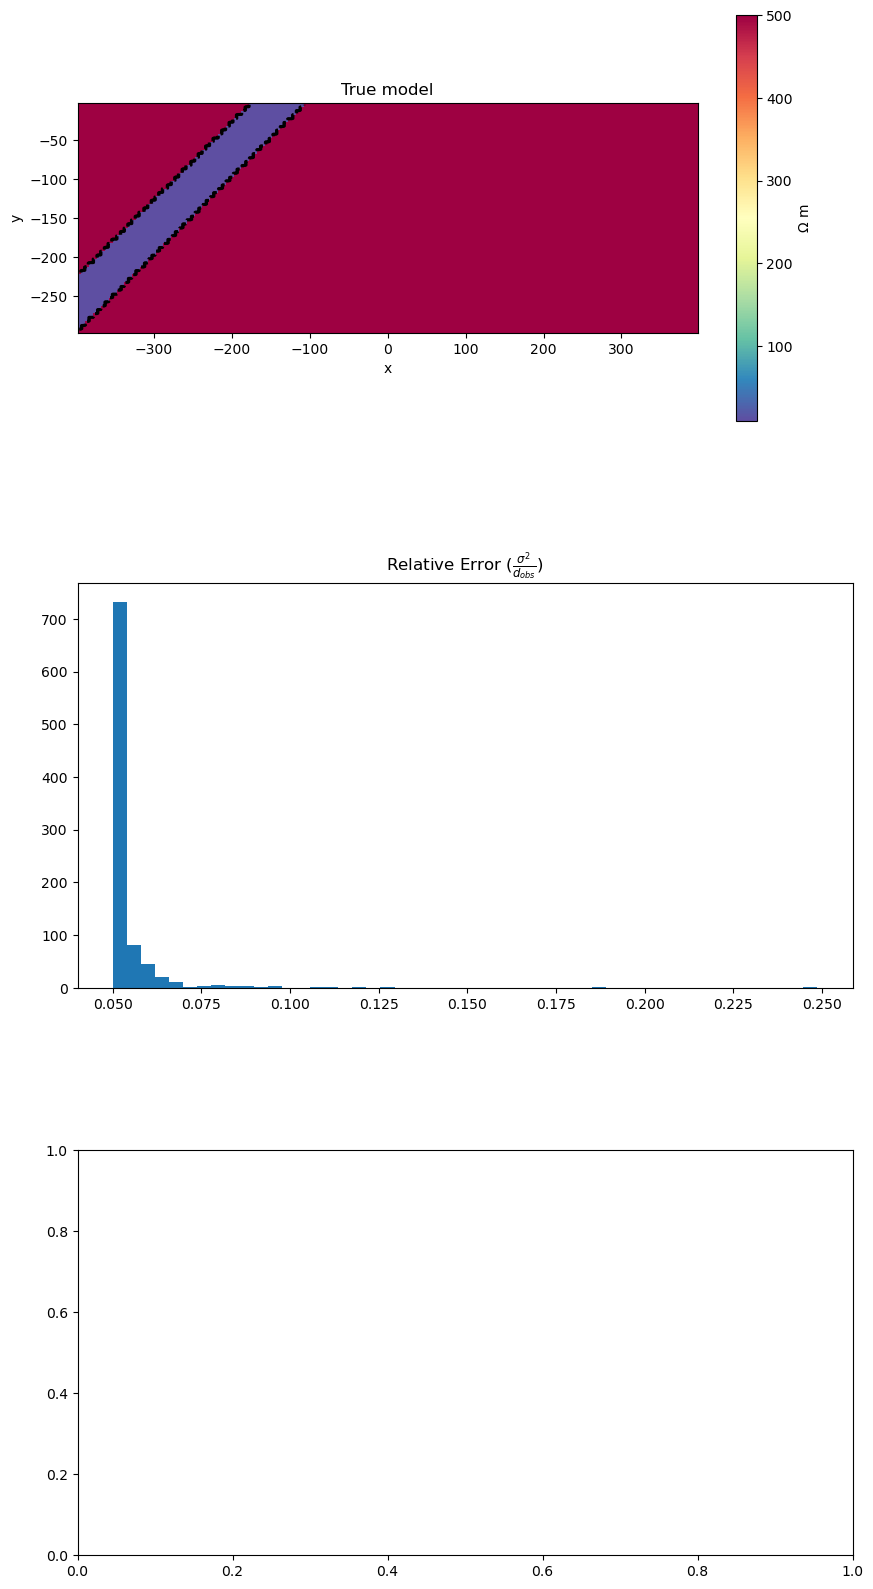

In [16]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 45*
dike0 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 100)
dike1 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 175)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(10,20))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

ax[0].set_xlim([-1000,1000])
ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
mm = meshCore.plot_image(
    
    1/(cond_true)[actcore],
    ax=ax[0],
    pcolorOpts={'cmap':'Spectral_r'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
ax[0].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[0].set_title('True model')

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.05
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=1e-4,
    force=True,
    add_noise=True,

)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')
# plt.show()



m0 = np.log(1/500) * np.ones(mapping.nP)


plt.subplots_adjust( 
                wspace=0.4, 
                hspace=0.4)


# --------------------------------------------------------------------------

# setup the inversion

#

dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))
# set the regularization
alphas = np.ones((meshCore.n_cells, meshCore.dim))
# alphas[meshCore.cell_centers[:, 1] < 0.5] = [2, 1]
sqrt2 = np.sqrt(2)
# reg_dirs = np.array([[sqrt2, sqrt2], [sqrt2, sqrt2],])

# lets just assign them to the dip structure
reg_cell_dirs = [np.identity(2) for _ in range(meshCore.nC)]

# lets expand the area we want to
# Dike 45*
dike00 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 50)
dike01 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 255)
dike_dir_reg = np.logical_and(dike00,dike01)

# reg model
reg_model = model.copy()

reg_model[dike_dir_reg]=4

for ii in range(meshCore.nC):

    if reg_model[actcore][ii] == 4:

        reg_cell_dirs[ii] = np.array([[sqrt2, sqrt2], [sqrt2, sqrt2],])

# reg_cell_dirs[dike] = np.array([[sqrt2, sqrt2], [sqrt2, sqrt2],])
# segmentor = SamClassificationModel(
#     mesh,
# )

# reg_mean = GeologicalSegmentation(
#     meshCore, 
#     reg_dirs=reg_cell_dirs,
#     ortho_check=False,
#     segmentation_model=segmentor
# )
reg_mean = regularization.SmoothnessFullGradient(
    meshCore, 
    reg_dirs=reg_cell_dirs,
    ortho_check=False,
    # segmentation_model=segmentor
)
# reg_mean = regularization.PGI(
#     gmm=gmmref,
#     gmmref=gmmref, 
#     mesh=mesh,
#     wiresmap=wires,
#     maplist=[idenMap],
#     reference_model=m0,
#     indActive=actcore
# )

# Weighting
# reg_mean = regularization.WeightedLeastSquares(
#     mesh, 
#     active_cells=actcore,
#     mapping=idenMap,
#     # reference_model=m0
# )
reg_mean.alpha_s = 0.01
reg_mean.alpha_x = 100
reg_mean.alpha_y = 100
# reg_mean.mrefInSmooth = True
# reg_mean.approx_gradient = True


# # Optimization
# opt = optimization.ProjectedGNCG(maxIter=8, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
# opt.remember('xc')

# # Set the inverse problem
# invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)

# # Inversion directives
# betaIt = directives.PGI_BetaAlphaSchedule(
#     verbose=True, coolingFactor=5.,
#     warmingFactor=1., tolerance=0.05,
#     progress=0.1
# )
# targets = directives.MultiTargetMisfits(
#     TriggerSmall=True,
#     TriggerTheta=False,
#     verbose=True,
# )
# MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
# petrodir = PGIUpdateParameters(
#     update_covariances=True,
#     kappa = 1e8,
#     nu = 1e8,
#     update_rate = 2,
#     update_reference_model=False
#     )
# # update_sam = update_segmentation_neighbours()
# plot_iter_mref = plot_mref()
# plot_iter_mref.mesh = meshCore
# updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
# update_Jacobi = directives.UpdatePreconditioner()
# save_pgi = SavePGIOutput('./pgi_param')
# invProb.beta = 1e-2


In [18]:
dip_model = np.load(r"C:\Users\johnk\Documents\git\jresearch\iterations\model_5.npy")

grad_reg = reg_mean.deriv(dip_model)

In [ ]:
import numpy as np
from scipy.ndimage import laplace

def minimum_curvature(input_matrix, num_iterations=100, alpha=0.1):
    for _ in range(num_iterations):
        # Calculate the Laplacian of the input matrix
        laplacian = laplace(input_matrix)

        # Update the input matrix using the Laplacian and a smoothing factor (alpha)
        input_matrix += alpha * laplacian

    return input_matrix

input_matrix = np.reshape(grad_reg, ())

# Apply minimum curvatureg
output_matrix = minimum_curvature(input_matrix)


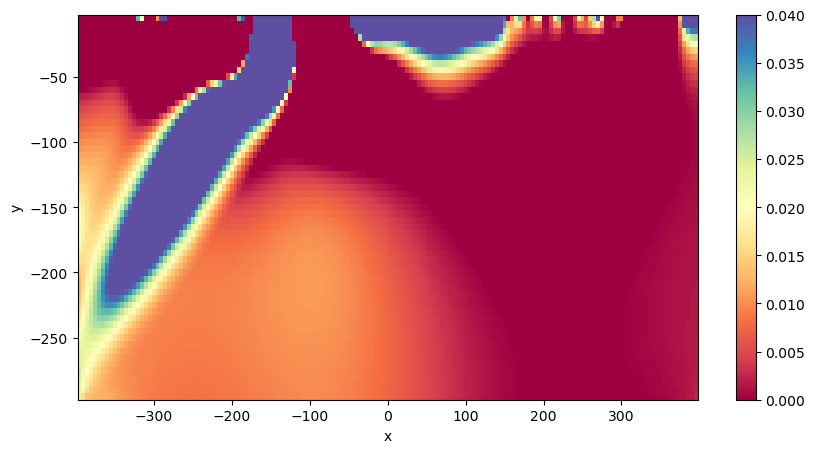

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
dat = meshCore.plotImage(grad_reg, ax=ax, clim=[0,0.04], pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])

In [ ]:
results = segmentor.masks
cnt = 1
for result in results:
    flatten = result['segmentation'].flatten(order='F')
    reshape = flatten.reshape(meshCore.shape_cells, order='F')

    plt.imshow(reshape.T)
    plt.title(f'mask: {cnt}')
    plt.gca().invert_yaxis()
    plt.show()
    cnt += 1
print(len(result))

flatten = dip_model
reshape = flatten.reshape(meshCore.shape_cells, order='F')

plt.imshow(reshape.T, cmap='Spectral_r')
plt.title(f'iteration: {6}',fontsize=15)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

fig, ax = plt.subplots(2, 2)

# mm = meshCore.plotImage(
    
#     1/(cond_true)[actcore],
#     ax=ax[0, 0],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

ax[0, 1].imshow(reshape.T, cmap='Spectral_r')
ax[0, 1].invert_yaxis()
ax[0, 1].set_title('Geophysical model iteration 6',fontsize=15)

flatten = (cond_true)[actcore]
reshape = flatten.reshape(meshCore.shape_cells, order='F')
ax[0, 0].imshow(reshape.T, cmap='Spectral_r')
ax[0, 0].invert_yaxis()
ax[0, 0].set_title('Geological True model',fontsize=15)
flatten = results[1]['segmentation'].flatten(order='F')
reshape = flatten.reshape(meshCore.shape_cells, order='F')
ax[1, 0].imshow(reshape.T)
ax[1, 0].invert_yaxis()
ax[1, 0].set_title('Mask: background',fontsize=15)
flatten = results[3]['segmentation'].flatten(order='F')
reshape = flatten.reshape(meshCore.shape_cells, order='F')
ax[1, 1].imshow(reshape.T)
ax[1, 1].invert_yaxis()
ax[1, 1].set_title('Mask: Dyke',fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you have a 2D mask represented as a binary image (0 for background, 1 for object)
# Replace 'your_mask_data' with your actual mask data
# The mask should be a 2D array with 1s for the object pixels and 0s for background

# Example mask (replace with your actual data)
your_mask_data = results[3]['segmentation']
your_mask_data = np.flip(your_mask_data)
# Find the coordinates of the object pixels
object_pixels = np.argwhere(your_mask_data == 1)

# Apply PPCA to determine orientation
if len(object_pixels) > 1:
    # Standardize the data
    scaler = StandardScaler()
    object_pixels_std = scaler.fit_transform(object_pixels)

    # Apply PPCA
    pca = PCA(n_components=2)
    pca.fit(object_pixels_std)

    # The first principal component (eigenvector) will represent the orientation
    orientation_vector = pca.components_[0]

    # Compute the angle of the orientation vector (in degrees)
    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

    print(f"Orientation angle (degrees): {angle_degrees}")
else:
    print("Not enough object pixels to determine orientation.")

# Find the center of the object by averaging the object pixel coordinates
object_center = object_pixels.mean(axis=0)

# Plot the mask
plt.imshow(your_mask_data.T, cmap='binary')

# Plot an arrow representing the orientation
arrow_length = 1
arrow_dx = arrow_length * np.cos(angle_degrees * np.pi / 180)
arrow_dy = arrow_length * np.sin(angle_degrees * np.pi / 180)
plt.arrow(object_center[0], object_center[1], arrow_dx + 8, arrow_dy+ 8,
          head_width=10, head_length=10, fc='r', ec='r')

# Show the plot
plt.gca().invert_xaxis()
plt.title('Principal Direction from PCA')
plt.show()